## Heart Failure Prediction

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm
import xgboost as xgb
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

#### Load Dataset

In [2]:
df = pd.read_csv(r"E:\Datasets\heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.shape

(299, 13)

#### About Dataset
- To Predict whether a patient will die during the follow-up period of a heart failure condition.
- target - DEATH_EVENT 
- 1 = Died, 0 = Survived
- Binary Classification

#### Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### Exploratory Data Analysis

#### Exploring target

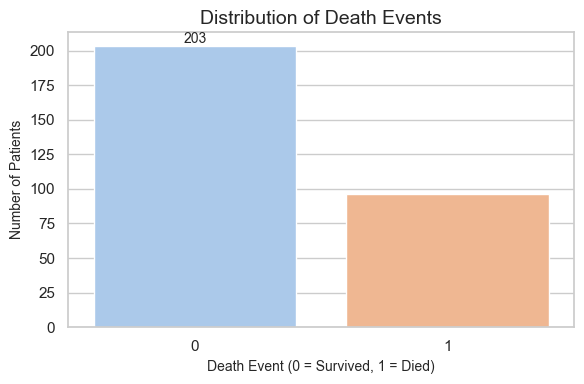

In [5]:
sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
ax = sns.countplot(data = df, x = "DEATH_EVENT", palette="pastel")
ax.bar_label(ax.containers[0], fontsize=10)

plt.title("Distribution of Death Events", fontsize=14)
plt.xlabel("Death Event (0 = Survived, 1 = Died)", fontsize=10)
plt.ylabel("Number of Patients", fontsize=10)
plt.tight_layout()
plt.show()

- Target labels are 203 vs 986 --> class imbalance in the data

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


- creatinine_phosphokinase - Average is 581, but max is 7861, means someone has a very unusual level.
- serum_creatinine - Avg is 1.39, but max is 9.4, someone has unusual figure
- ejection_fraction - Avg is 38, but min is 14, someone has low

#### Bivariate Analysis - by examining corr of all features using heatmap

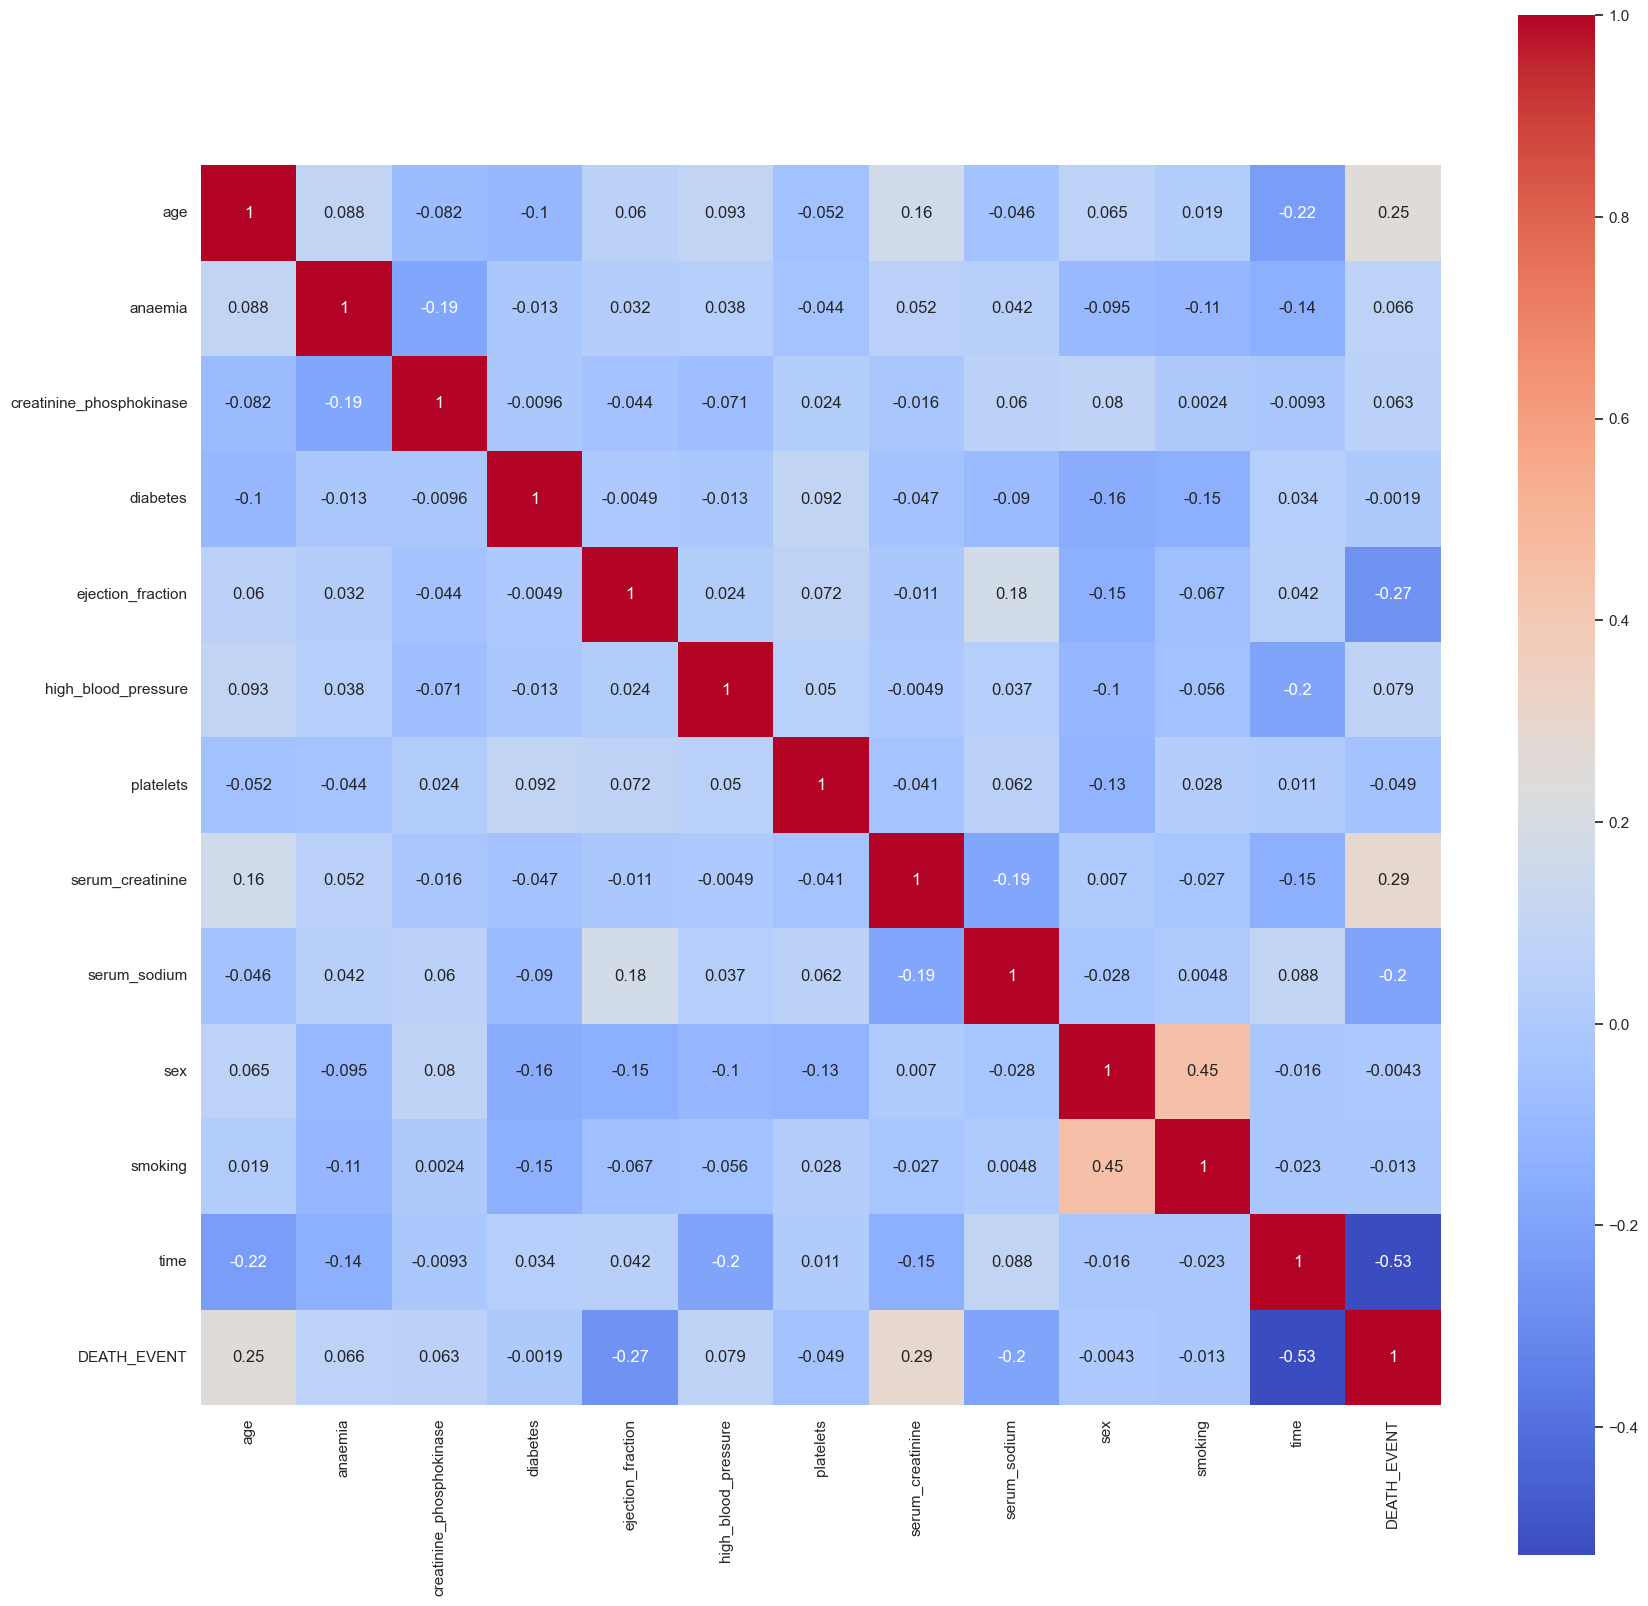

In [7]:
corr_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,
           annot=True,
           cmap='coolwarm',
           square=True)
plt.show()

#### Exploring Age as per the death happened

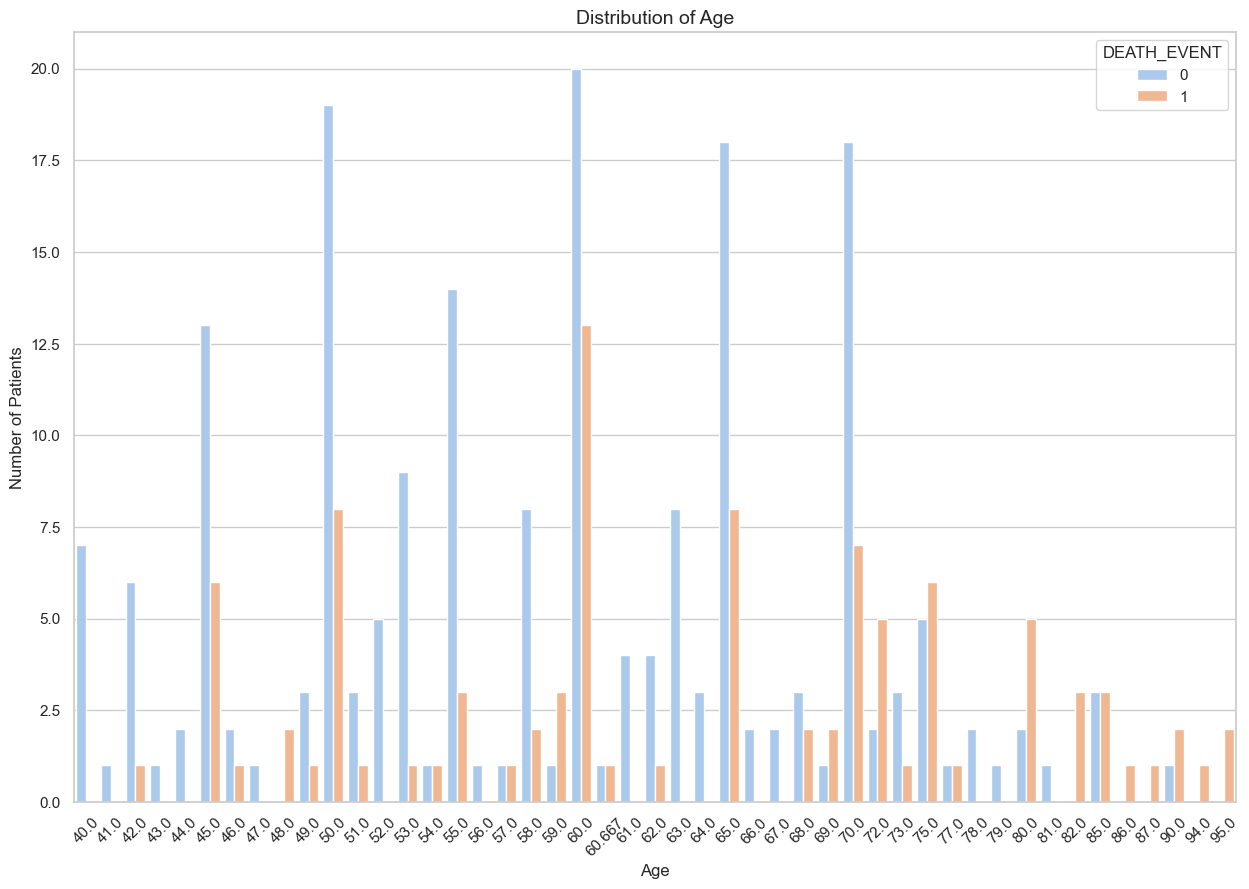

In [8]:
plt.figure(figsize=(15, 10))
sns.countplot(x=df['age'], data=df, hue='DEATH_EVENT', palette="pastel")
plt.title("Distribution of Age", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.show()

#### Explore Age

<Axes: xlabel='age', ylabel='Count'>

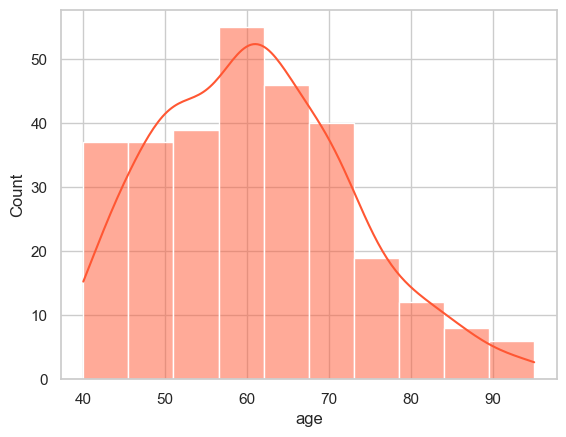

In [9]:
# define colors for plot
custom_colors = ["#FF5733", "#3366FF", "#33FF57"]

# plot histogram
sns.histplot(df['age'], kde=True, color="#FF5733", palette=custom_colors)

#### Exploring certain columns

In [10]:
# define features
features = ["age", "creatinine_phosphokinase", "ejection_fraction", 
            "platelets", "serum_creatinine", "serum_sodium", "time"]

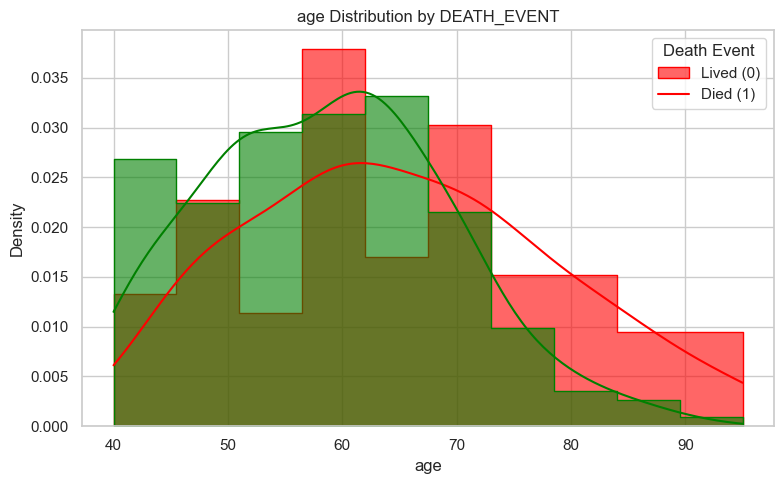

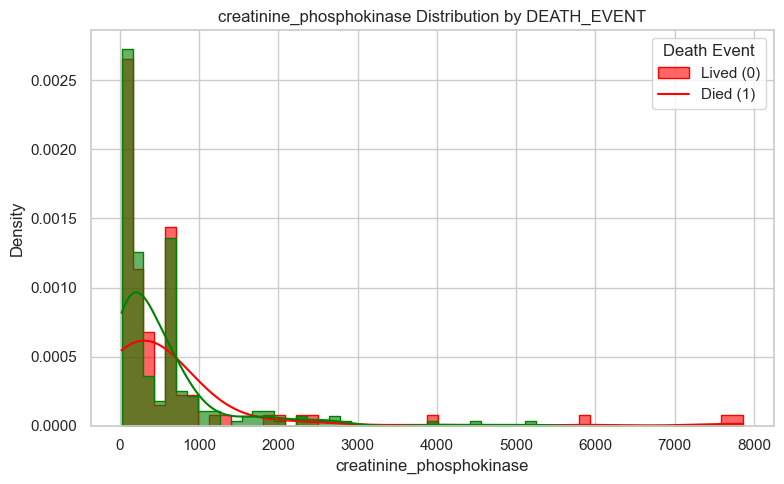

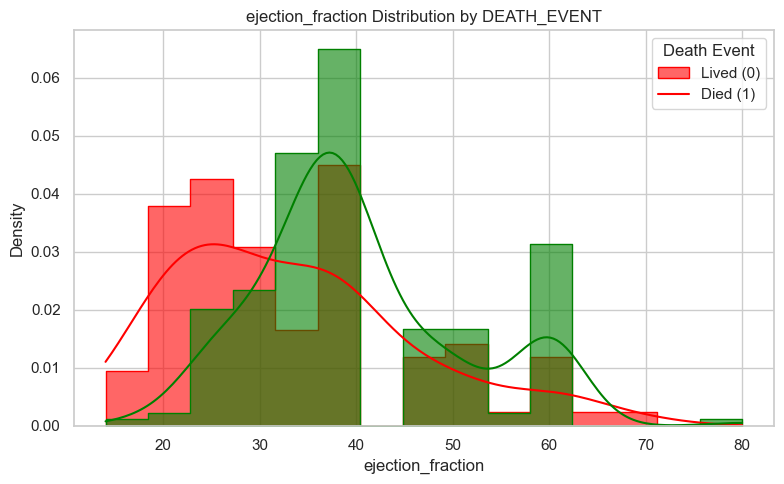

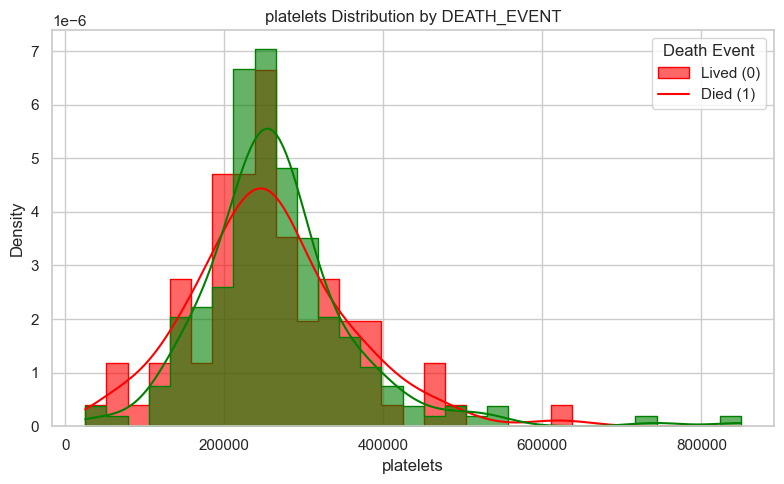

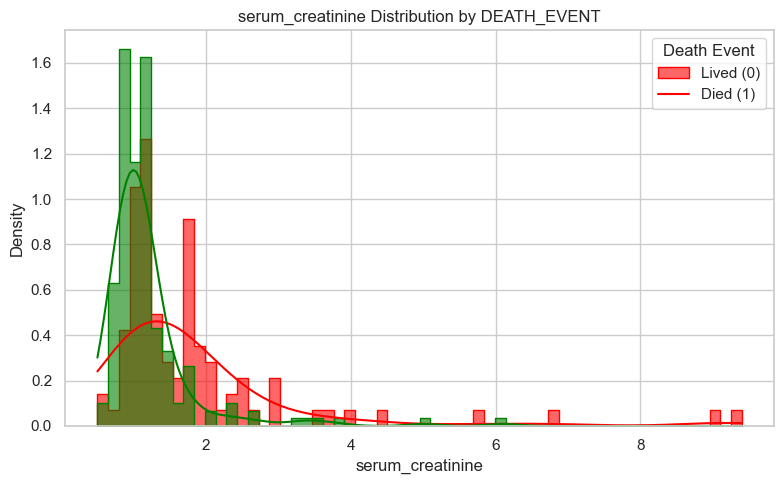

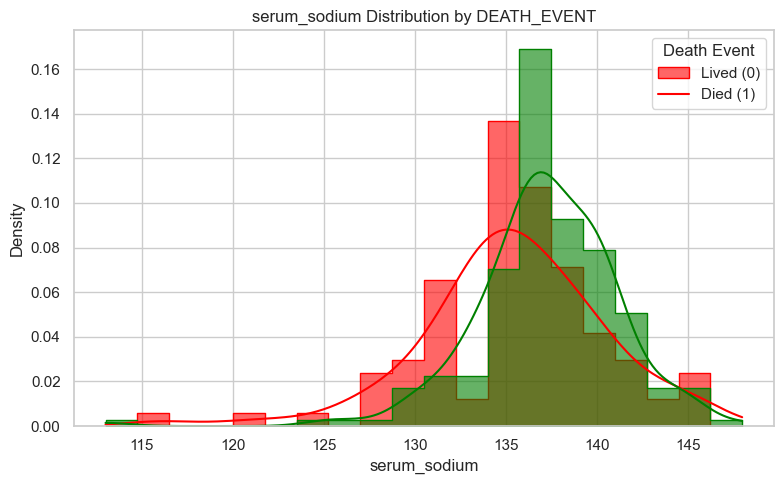

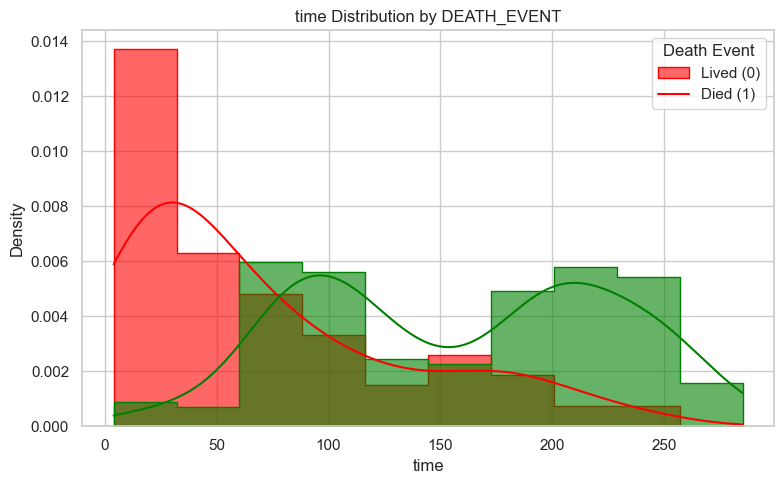

In [11]:
for feature in features:
    plt.figure(figsize =(8,5))

    # plot histplot for people who lived (0) and died (1)
    sns.histplot(data=df, x=feature, hue="DEATH_EVENT", kde=True, element="step",
                stat="density", common_norm=False, 
                 palette={0: "green",1: "red"}, alpha=0.6)

    plt.title(f"{feature} Distribution by DEATH_EVENT")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend(title="Death Event", labels=["Lived (0)", "Died (1)"])
    plt.tight_layout()
    plt.show()

### Data Preprocessing

In [12]:
X = df.drop(['DEATH_EVENT'], axis=1)
y = df['DEATH_EVENT']

#### Feature Scaling - Standard Scaler

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Covert Cleaned DataFrame 

In [14]:
X_cleaned = pd.DataFrame(X_scaled, columns=X.columns)

### Model Building

#### Splitting the Dataset into train and test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.3,
                                                   random_state=42)

#### Handling Class imbalance

In [16]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE: ", np.bincount(y_train_res))

After SMOTE:  [150 150]


#### Evaluation Function

In [17]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n====={model_name} Evaluation =====")
    print("Confusion Matrix: \n", confusion_matrix(y_true, y_pred))
    print("Classification Report: \n", classification_report(y_true, y_pred))
    print("ROC AUC score: ", roc_auc_score(y_true, y_pred))

#### 1. Support Vector Machine (SVM)

In [18]:
svm_model = svm.SVC()
svm_model.fit(X_train_res, y_train_res)
y_pred_svm = svm_model.predict(X_test)

evaluate_model(y_test, y_pred_svm, "Support Vector Machine")


=====Support Vector Machine Evaluation =====
Confusion Matrix: 
 [[46  7]
 [14 23]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.87      0.81        53
           1       0.77      0.62      0.69        37

    accuracy                           0.77        90
   macro avg       0.77      0.74      0.75        90
weighted avg       0.77      0.77      0.76        90

ROC AUC score:  0.7447730749617542


#### 2. Gradient Bossting Machines (GBM) or XGBoost

In [19]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metrics='logloss',
                             random_state=42)
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model(y_test, y_pred_xgb, "XGBoost")


=====XGBoost Evaluation =====
Confusion Matrix: 
 [[48  5]
 [15 22]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.91      0.83        53
           1       0.81      0.59      0.69        37

    accuracy                           0.78        90
   macro avg       0.79      0.75      0.76        90
weighted avg       0.78      0.78      0.77        90

ROC AUC score:  0.7501274859765427


#### 3. Artificial Neural Network (ANN)

In [20]:
# class imbalance
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=20,
                                        restore_best_weights=True)

In [21]:
# Initialize NN
model = Sequential()

In [22]:
# layers
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu',
                 input_dim = 12))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

In [23]:
# Compile the ANN
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
# Train the ANN
model.fit(X_train_res, y_train_res, 
          batch_size=25, 
          epochs=80, 
          callbacks=[early_stopping],
          validation_split=0.25)

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5896 - loss: 0.6928 - val_accuracy: 0.0000e+00 - val_loss: 0.6974
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6600 - loss: 0.6915 - val_accuracy: 0.0000e+00 - val_loss: 0.7015
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6803 - loss: 0.6898 - val_accuracy: 0.0000e+00 - val_loss: 0.7057
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6889 - loss: 0.6882 - val_accuracy: 0.0000e+00 - val_loss: 0.7099
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6189 - loss: 0.6890 - val_accuracy: 0.0000e+00 - val_loss: 0.7137
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6866 - loss: 0.6855 - val_accuracy: 0.0000e+00 - val_loss: 0.7180
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6992 - loss: 0.6834 - val_accuracy: 0.0000e+00 - val_loss: 0.7221
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6479 - loss: 0.6848 - val_accuracy: 0

In [25]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5835 - loss: 0.6925 
Test Loss: 0.6924
Test Accuracy: 0.5889


In [26]:
# For models like Keras or LogisticRegression that output probabilities
y_pred_prob = model.predict(X_test)
# Convert to class labels using a threshold (commonly 0.5)
y_pred_nn = (y_pred_prob > 0.5).astype(int).flatten()

evaluate_model(y_test, y_pred_nn, "Neural Network")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

=====Neural Network Evaluation =====
Confusion Matrix: 
 [[53  0]
 [37  0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.59      1.00      0.74        53
           1       0.00      0.00      0.00        37

    accuracy                           0.59        90
   macro avg       0.29      0.50      0.37        90
weighted avg       0.35      0.59      0.44        90

ROC AUC score:  0.5
